# Preprocessing

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from scipy import stats
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler

# warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")

train_ids = df_train['Id']
test_ids = df_test['Id']


df_full = pd.concat([df_train,df_test], sort=False)

## EDA

columns with null values

In [25]:
nans = pd.concat([df_train.isnull().sum(),
                  df_train.isnull().sum()/
                  df_train.shape[0], df_test.isnull().sum(),
                  df_test.isnull().sum()/
                  df_test.shape[0]], axis=1,
                 keys=['Train', 'Percentage', 'Test', 'Percentage'],
                sort=False)
print(nans[nans.sum(axis=1) > 0].sort_values(by="Test", ascending=False))

              Train  Percentage    Test  Percentage
PoolQC         1453    0.995205  1456.0    0.997944
MiscFeature    1406    0.963014  1408.0    0.965045
Alley          1369    0.937671  1352.0    0.926662
Fence          1179    0.807534  1169.0    0.801234
FireplaceQu     690    0.472603   730.0    0.500343
LotFrontage     259    0.177397   227.0    0.155586
GarageFinish     81    0.055479    78.0    0.053461
GarageQual       81    0.055479    78.0    0.053461
GarageCond       81    0.055479    78.0    0.053461
GarageYrBlt      81    0.055479    78.0    0.053461
GarageType       81    0.055479    76.0    0.052090
BsmtCond         37    0.025342    45.0    0.030843
BsmtExposure     38    0.026027    44.0    0.030158
BsmtQual         37    0.025342    44.0    0.030158
BsmtFinType1     37    0.025342    42.0    0.028787
BsmtFinType2     38    0.026027    42.0    0.028787
MasVnrType        8    0.005479    16.0    0.010966
MasVnrArea        8    0.005479    15.0    0.010281
MSZoning    

categorical features

In [4]:
for idx in df_train.select_dtypes(include="object").columns:
    print("{}: {}\n".format(idx, set(df_train[idx])))

MSZoning: {'C (all)', 'RL', 'RH', 'FV', 'RM'}

Street: {'Pave', 'Grvl'}

Alley: {nan, 'Pave', 'Grvl'}

LotShape: {'Reg', 'IR2', 'IR1', 'IR3'}

LandContour: {'Bnk', 'Low', 'Lvl', 'HLS'}

Utilities: {'NoSeWa', 'AllPub'}

LotConfig: {'FR2', 'FR3', 'Inside', 'Corner', 'CulDSac'}

LandSlope: {'Gtl', 'Mod', 'Sev'}

Neighborhood: {'Timber', 'NPkVill', 'MeadowV', 'NridgHt', 'Gilbert', 'NAmes', 'IDOTRR', 'Mitchel', 'Somerst', 'Veenker', 'CollgCr', 'SawyerW', 'Edwards', 'BrDale', 'Blueste', 'NWAmes', 'Crawfor', 'Sawyer', 'BrkSide', 'ClearCr', 'OldTown', 'Blmngtn', 'StoneBr', 'NoRidge', 'SWISU'}

Condition1: {'PosA', 'RRAe', 'Feedr', 'RRNe', 'RRAn', 'RRNn', 'PosN', 'Artery', 'Norm'}

Condition2: {'PosA', 'RRAe', 'Feedr', 'RRAn', 'RRNn', 'PosN', 'Artery', 'Norm'}

BldgType: {'Duplex', '2fmCon', '1Fam', 'Twnhs', 'TwnhsE'}

HouseStyle: {'2.5Fin', '2.5Unf', '1.5Fin', 'SLvl', 'SFoyer', '2Story', '1Story', '1.5Unf'}

RoofStyle: {'Shed', 'Mansard', 'Gable', 'Hip', 'Flat', 'Gambrel'}

RoofMatl: {'WdShake

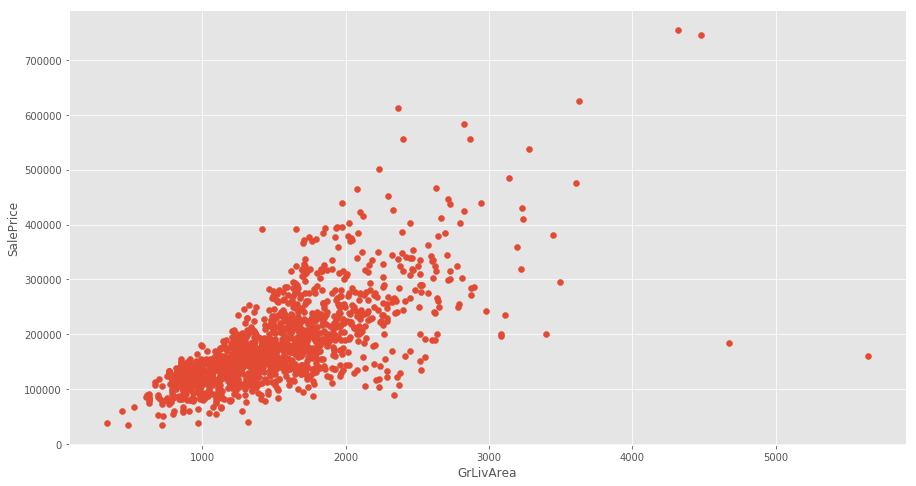

In [5]:
plt.figure(figsize=(15,8))
plt.scatter(df_train["GrLivArea"], df_train["SalePrice"])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

```there are 2 big houses with very low price.```

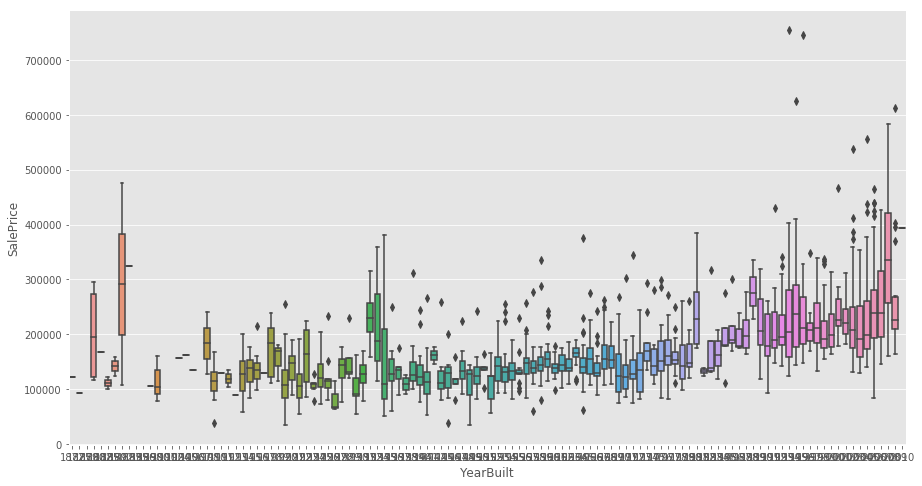

In [6]:
plt.figure(figsize=(15, 8))
sns.boxplot(df_full.YearBuilt, df_full.SalePrice)
plt.show()

```prices increase over years```

In [7]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

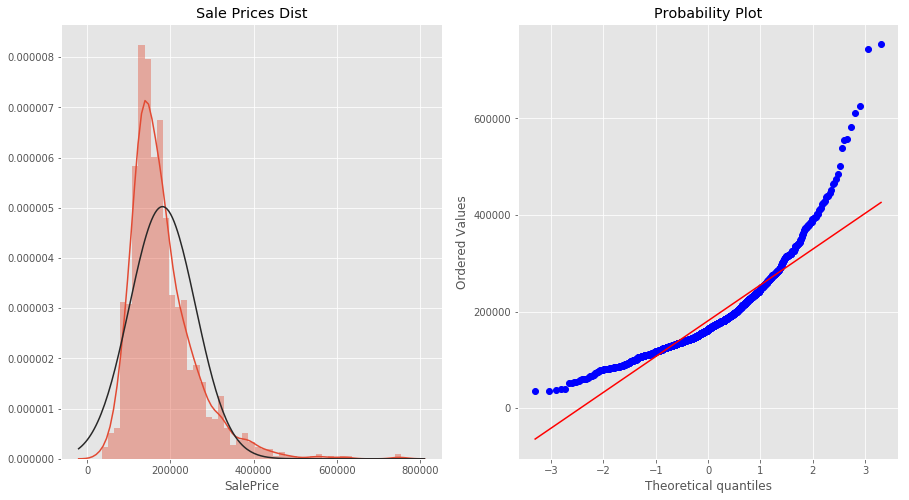

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("Sale Prices Dist")
sns.distplot(df_train["SalePrice"], fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(df_train["SalePrice"], plot=plt)
plt.show()

print("Skewness: %f" % df_train["SalePrice"].skew())
print("Kurtosis: %f" % df_train["SalePrice"].kurt())

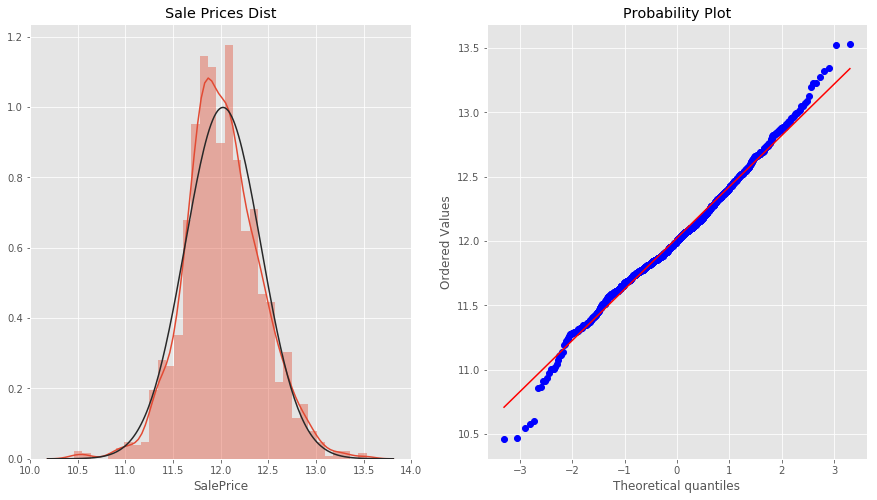

Skewness: 0.121335
Kurtosis: 0.809532


In [9]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("Sale Prices Dist")
sns.distplot(np.log(df_train["SalePrice"]), fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(np.log(df_train["SalePrice"]), plot=plt)
plt.show()

print("Skewness: %f" % np.log(df_train["SalePrice"]).skew())
print("Kurtosis: %f" % np.log(df_train["SalePrice"]).kurt())

``` seems like using log values is closer to normal distribution```

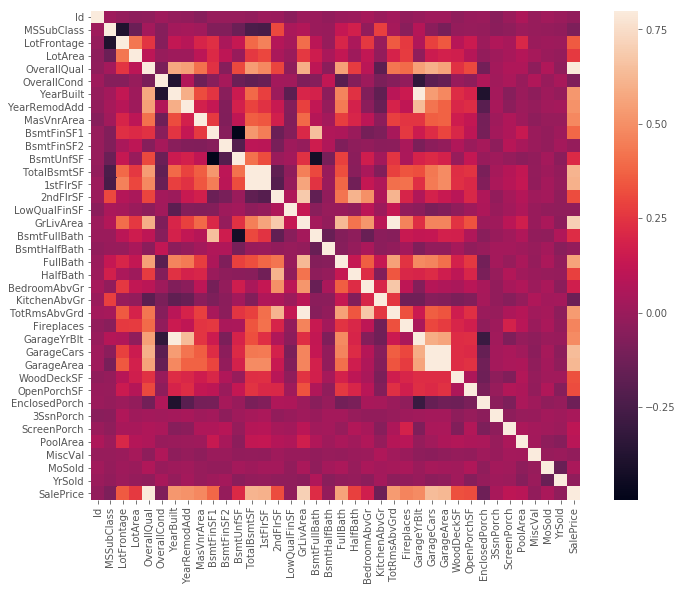

In [10]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

```values related to garage are correlated. alse basement finished area and first floor```

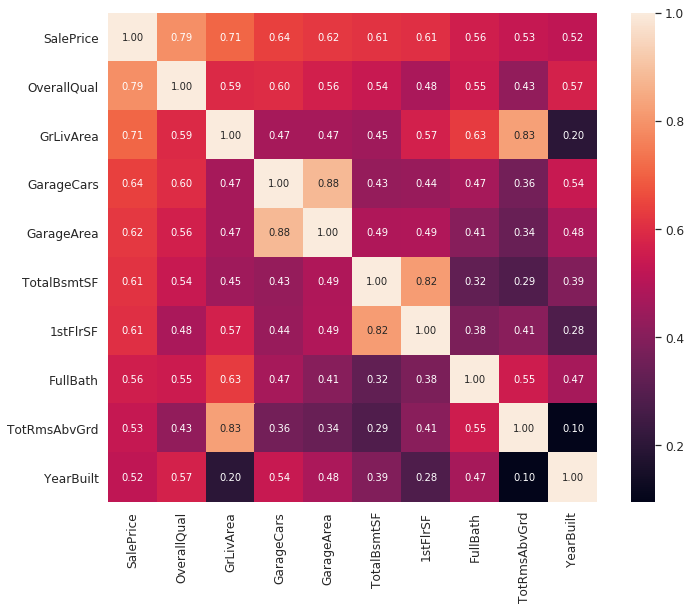

In [11]:
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

<Figure size 1152x648 with 0 Axes>

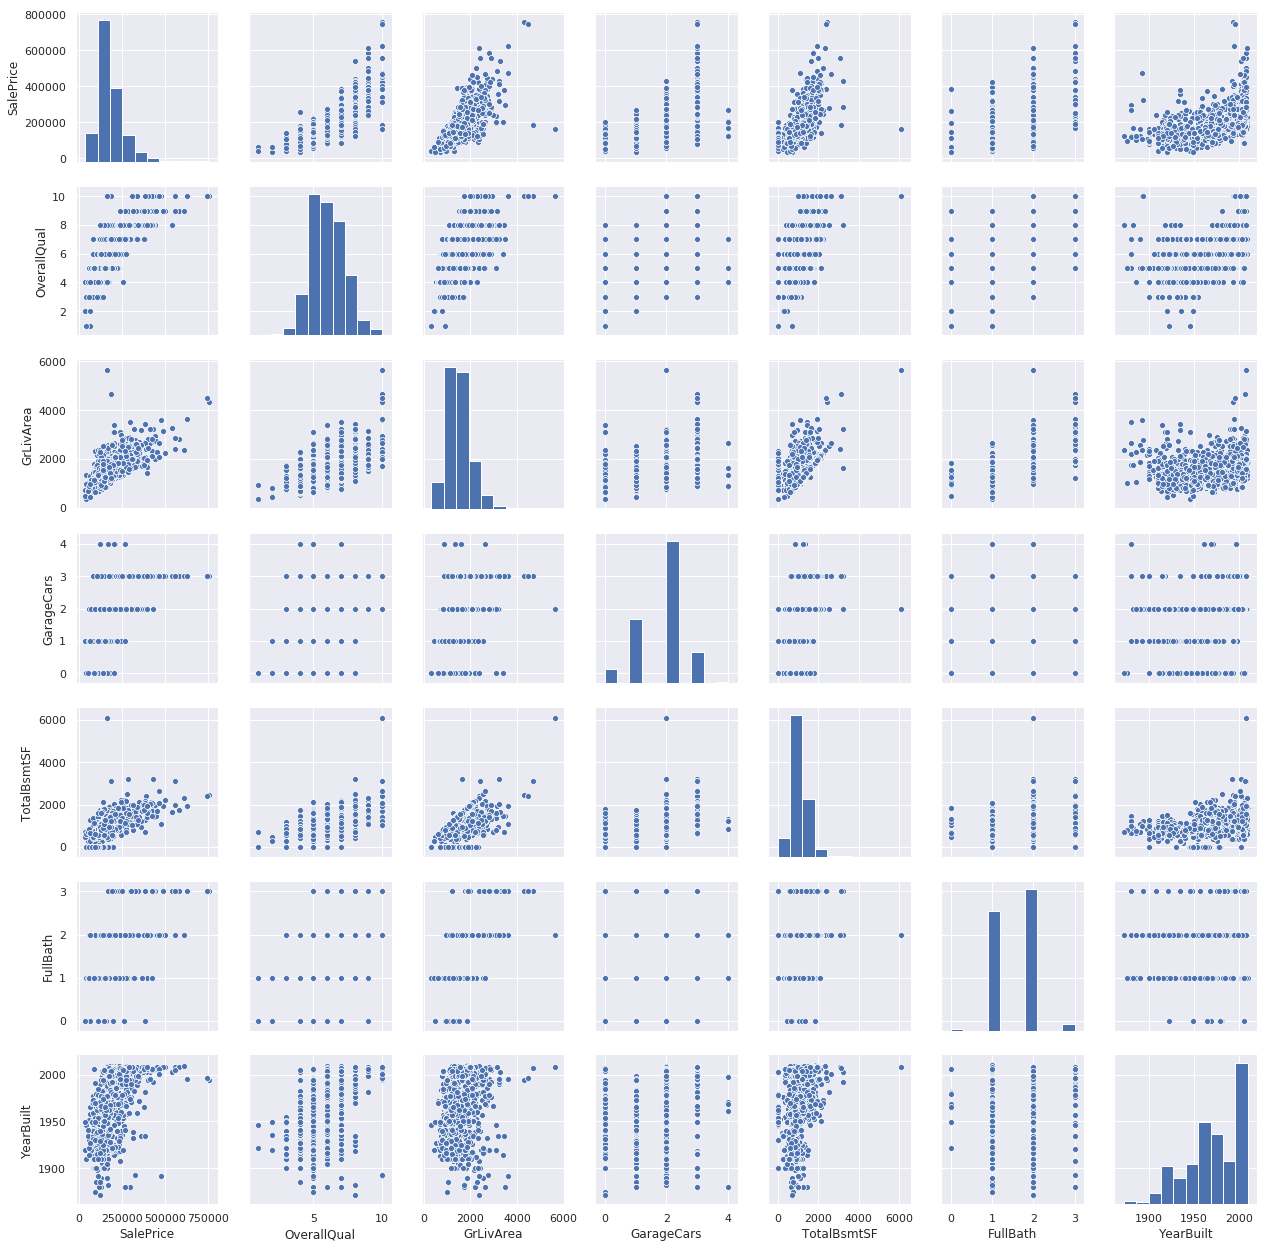

In [12]:
sns.set()
plt.figure(figsize=(16, 9))
cols = ['SalePrice', 'OverallQual','GrLivArea', 'GarageCars',
        'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height=2.5)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


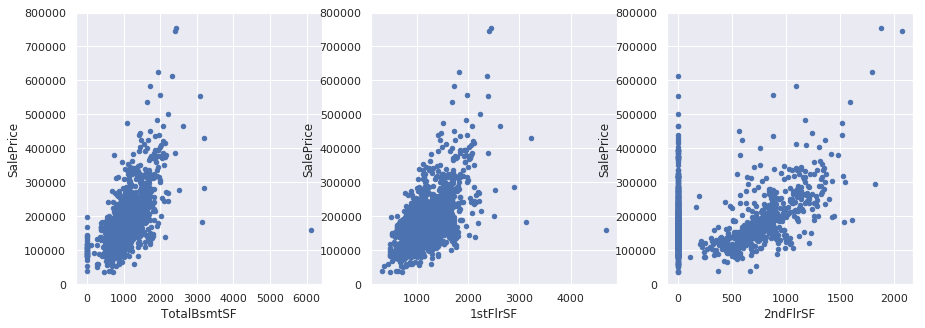

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
data_total = pd.concat([df_train['SalePrice'],
                        df_train['TotalBsmtSF']], axis=1)
data_total.plot.scatter(x='TotalBsmtSF', y='SalePrice',
                        ylim=(0, 800000), ax=ax1)
data1 = pd.concat([df_train['SalePrice'], df_train['1stFlrSF']], axis=1)
data1.plot.scatter(x='1stFlrSF', y='SalePrice', ylim=(0, 800000), ax=ax2)
data2 = pd.concat([df_train['SalePrice'], df_train['2ndFlrSF']], axis=1)
data2.plot.scatter(x='2ndFlrSF', y='SalePrice', ylim=(0, 800000), ax=ax3)
plt.show()

In [14]:
df_full.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)
df_full['TotalBsmtSF'] = df_full['TotalBsmtSF'].fillna(0)
df_full['1stFlrSF'] = df_full['1stFlrSF'].fillna(0)
df_full['2ndFlrSF'] = df_full['2ndFlrSF'].fillna(0)
df_full['TotalSF'] = df_full['TotalBsmtSF']+df_full['1stFlrSF']+df_full['2ndFlrSF']
df_full.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
df_full.drop(['GarageArea'], axis=1, inplace=True) 

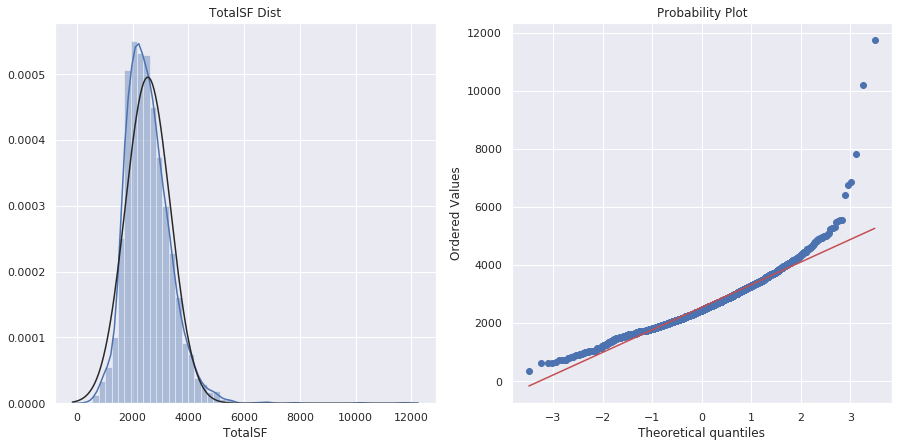

Skewness: 1.512256
Kurtosis: 9.794044


In [15]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("TotalSF Dist")
sns.distplot(df_full['TotalSF'], fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(df_full['TotalSF'], plot=plt)
plt.show()

print("Skewness: %f" % df_full['TotalSF'].skew())
print("Kurtosis: %f" % df_full['TotalSF'].kurt())

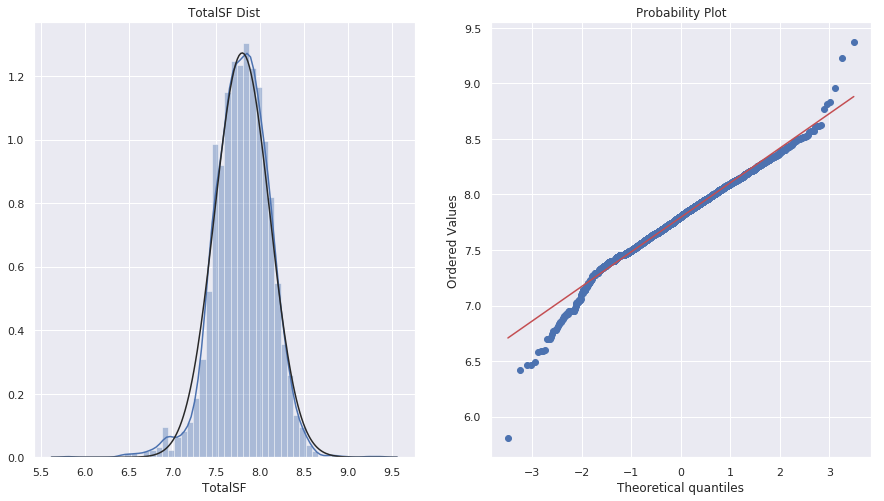

Skewness: -0.369511
Kurtosis: 1.662947


In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("TotalSF Dist")
sns.distplot(np.log(df_full["TotalSF"]), fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(np.log(df_full["TotalSF"]), plot=plt)
plt.show()

print("Skewness: %f" % np.log(df_full["TotalSF"]).skew())
print("Kurtosis: %f" % np.log(df_full["TotalSF"]).kurt())

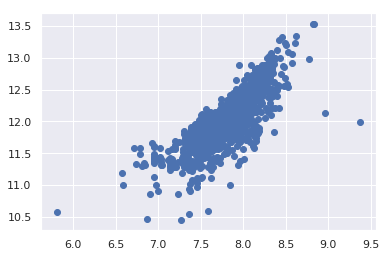

In [17]:
sf = np.log(df_full['TotalSF'])
sp = np.log(df_full['SalePrice'])
plt.scatter(sf[sf > 0], sp[sf > 0])
plt.show()

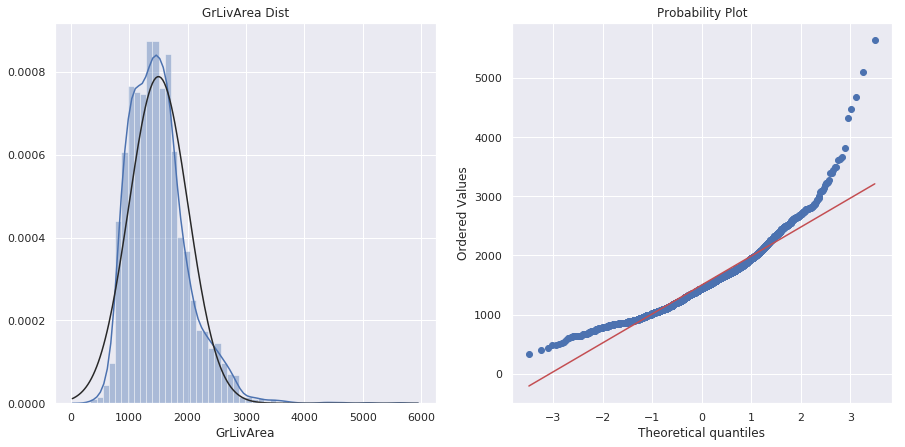

Skewness: 1.270010
Kurtosis: 4.121604


In [18]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("GrLivArea Dist")
sns.distplot(df_full['GrLivArea'], fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(df_full['GrLivArea'], plot=plt)
plt.show()

print("Skewness: %f" % df_full['GrLivArea'].skew())
print("Kurtosis: %f" % df_full['GrLivArea'].kurt())

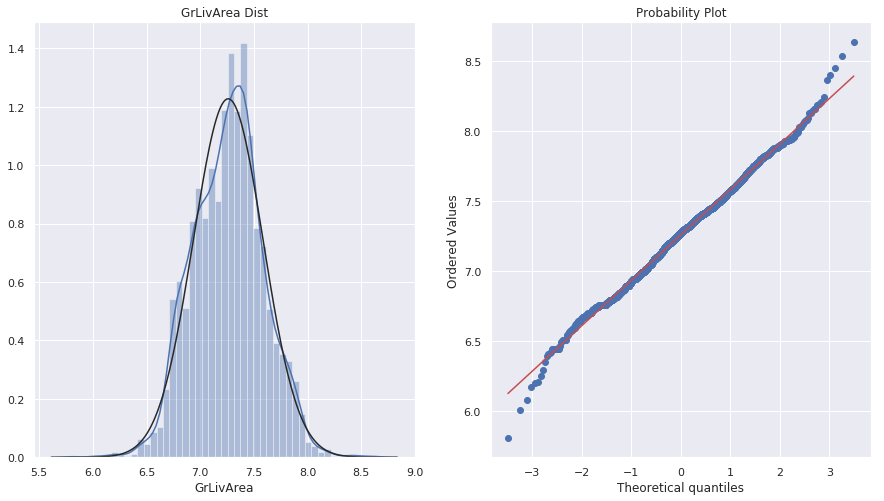

Skewness: 0.012386
Kurtosis: 0.212402


In [19]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("GrLivArea Dist")
sns.distplot(np.log(df_full["GrLivArea"]), fit=stats.norm)

plt.subplot(1, 2, 2)
stats.probplot(np.log(df_full["GrLivArea"]), plot=plt)
plt.show()

print("Skewness: %f" % np.log(df_full["GrLivArea"]).skew())
print("Kurtosis: %f" % np.log(df_full["GrLivArea"]).kurt())

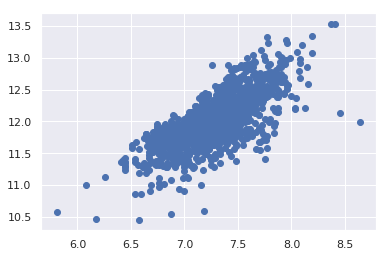

In [20]:
sf = np.log(df_full['GrLivArea'])
sp = np.log(df_full['SalePrice'])
plt.scatter(sf[sf > 0], sp[sf > 0])
plt.show()

## Treat missing values

In [21]:
df_full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean',
                                                        'median','count'])


LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        66.910112   65.0   178
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [22]:
df_full["LotAreaCut"] = pd.qcut(df_full.LotArea,10)

In [23]:
df_full.groupby(['LotAreaCut'])[['LotFrontage']].agg(
    ['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4922.4]    35.741036   34.0   251
(4922.4, 7007.6]      55.460674   52.0   267
(7007.6, 7960.4]      63.008000   62.0   250
(7960.4, 8741.0]      66.964844   65.0   256
(8741.0, 9453.0]      70.106996   70.0   243
(9453.0, 10151.6]     73.972656   75.0   256
(10151.6, 11001.2]    73.650794   75.0   252
(11001.2, 12203.8]    83.377193   82.0   228
(12203.8, 14300.6]    84.991228   85.0   228
(14300.6, 215245.0]   94.188119   90.0   202

In [24]:
df_full['LotFrontage'] = df_full.groupby(
    ['LotAreaCut','Neighborhood'])['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# for remaining null values
df_full['LotFrontage'] = df_full.groupby(
    ['LotAreaCut'])['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
cols=["MasVnrArea","GarageCars"]
for col in cols:
    df_full[col].fillna(0, inplace=True)



In [33]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu",
         "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt",
         "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual",
         "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    df_full[col].fillna("None", inplace=True)



In [34]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities",
         "Functional", "Electrical", "KitchenQual", "SaleType",
         "Exterior1st", "Exterior2nd"]
for col in cols2:
    df_full[col].fillna(df_full[col].mode()[0], inplace=True)


In [35]:
df_full.isnull().sum()[df_full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [50]:
int_cols = ["BsmtFullBath", "BsmtHalfBath", "BedroomAbvGr"]
for col in int_cols:
    df_full[col].astype(int)

In [61]:
df_full.groupby(['MSSubClass'])[['SalePrice']].agg(
    ['mean','median','count']).sort_values(by=(
    "SalePrice","median"), ascending=False)

SalePrice                
                     mean    median count
MSSubClass                               
60          239948.501672  215200.0   299
120         200779.080460  192000.0    87
80          169736.551724  166500.0    58
75          192437.500000  163500.0    16
20          185224.811567  159250.0   536
70          166772.416667  156000.0    60
160         138647.380952  146000.0    63
40          156125.000000  142500.0     4
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52
50          143302.972222  132000.0   144
190         129613.333333  128250.0    30
45          108591.666667  107500.0    12
30           95829.724638   99900.0    69
180         102300.000000   88500.0    10
150                   NaN       NaN     0

```now by studying medians we group them into 6 groups and 150 to the mode
       180 -> 1
       30, 45 -> 2
       190, 50, 90 -> 3
       85, 40, 160 -> 4
       70, 20, 75, 80, 150 -> 5
       120, 60 -> 6```

In [88]:
df_full["nfMSSubClass"] = df_full.MSSubClass.map({'180':1,
                                            '30':2, '45':2, 
                                            '190':3, '50':3, '90':3, 
                                            '85':4, '40':4, '160':4, 
                                            '70':5, '20':5, '75':5,
                                            '80':5, '150':5,
                                            '120': 6, '60':6})

In [89]:
df_full["nfMSZoning"] = df_full.MSZoning.map({'C (all)':1, 'RH':2,
                                              'RM':2, 'RL':3, 'FV':4})
    
df_full["nfNeighborhood"] = df_full.Neighborhood.map({'MeadowV':1,
                                                      'IDOTRR':2,
                                                      'BrDale':2,
                                                      'OldTown':3,
                                                      'Edwards':3,
                                                      'BrkSide':3,
                                                      'Sawyer':4,
                                                      'Blueste':4,
                                                      'SWISU':4,
                                                      'NAmes':4,
                                                      'NPkVill':5,
                                                      'Mitchel':5,
                                                      'SawyerW':6,
                                                      'Gilbert':6,
                                                      'NWAmes':6,
                                                      'Blmngtn':7,
                                                      'CollgCr':7,
                                                      'ClearCr':7,
                                                      'Crawfor':7,
                                                      'Veenker':8,
                                                      'Somerst':8,
                                                      'Timber':8,
                                                      'StoneBr':9,
                                                      'NoRidge':10,
                                                      'NridgHt':10})
    
df_full["nfCondition1"] = df_full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
df_full["nfBldgType"] = df_full.BldgType.map({'2fmCon':1,'Duplex':1,
                                              'Twnhs':1, '1Fam':2,
                                              'TwnhsE':2})
    
df_full["nfHouseStyle"] = df_full.HouseStyle.map({'1.5Unf':1,'1.5Fin':2,
                                                  '2.5Unf':2, 'SFoyer':2,
                                                  '1Story':3, 'SLvl':3,
                                                  '2Story':4, '2.5Fin':4})
    
df_full["nfExterior1st"]=df_full.Exterior1st.map({'BrkComm':1,'AsphShn':2,
                                                  'CBlock':2, 'AsbShng':2,
                                                  'WdShing':3,'Wd Sdng':3,
                                                  'MetalSd':3, 'Stucco':3,
                                                  'HdBoard':3,'BrkFace':4,
                                                  'Plywood':4,'VinylSd':5,
                                                  'CemntBd':6,'Stone':7,
                                                  'ImStucc':7})

df_full["nfMasVnrType"] = df_full.MasVnrType.map({'BrkCmn':1, 'None':1,
                                                  'BrkFace':2, 'Stone':3})

df_full["nfExterQual"] = df_full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3,
                                                'Ex':4})
    
df_full["nfFoundation"] = df_full.Foundation.map({'Slab':1,'BrkTil':2,
                                               'CBlock':2, 'Stone':2,
                                               'Wood':3, 'PConc':4})
    
df_full["nfBsmtQual"] = df_full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3,
                                              'Gd':4, 'Ex':5})
    
df_full["nfBsmtExposure"] = df_full.BsmtExposure.map({'None':1, 'No':2,
                                                      'Av':3, 'Mn':3,
                                                      'Gd':4})
    
df_full["nfHeating"] = df_full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2,
                                          'OthW':3, 'GasW':4, 'GasA':5})

df_full["nfHeatingQC"] = df_full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3,
                                                'Gd':4, 'Ex':5})
    
df_full["nfKitchenQual"] = df_full.KitchenQual.map({'Fa':1, 'TA':2,
                                                    'Gd':3, 'Ex':4})
    
df_full["nfFunctional"] = df_full.Functional.map({'Maj2':1, 'Maj1':2,
                                                  'Min1':2, 'Min2':2,
                                                  'Mod':2, 'Sev':2,
                                                  'Typ':3})
    
df_full["nfFireplaceQu"] = df_full.FireplaceQu.map({'None':1, 'Po':1,
                                                    'Fa':2, 'TA':3,
                                                    'Gd':4, 'Ex':5})
    
df_full["nfGarageType"] = df_full.GarageType.map({'CarPort':1, 'None':1,
                                                  'Detchd':2,'2Types':3,
                                                  'Basment':3,'Attchd':4,
                                                  'BuiltIn':5})
    
df_full["nfGarageFinish"] = df_full.GarageFinish.map({'None':1, 'Unf':2,
                                                      'RFn':3, 'Fin':4})
    
df_full["nfPavedDrive"] = df_full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
df_full["nfSaleType"] = df_full.SaleType.map({'COD':1, 'ConLD':1,
                                              'ConLI':1, 'ConLw':1,
                                              'Oth':1, 'WD':1,'CWD':2,
                                              'Con':3, 'New':3})
    
df_full["nfSaleCondition"] = df_full.SaleCondition.map({'AdjLand':1,
                                                        'Abnorml':2,
                                                        'Alloca':2,
                                                        'Family':2,
                                                        'Normal':3,
                                                        'Partial':4})

In [90]:
df_full.drop("LotAreaCut", axis=1, inplace=True)
df_full.drop(['SalePrice'], axis=1, inplace=True)

0